<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center>  Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. 

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



### Задание
1. Заполните код в этой тетрадке 
2. Если вы проходите специализацию Яндеса и МФТИ, пошлите тетрадку в соответствующем Peer Review. <br> Если вы проходите курс ODS, выберите ответы в [веб-форме](https://docs.google.com/forms/d/1EbjK7-hF-Gepi6RH-K5I2XeiYGRoY0LNDx03QmLu9Xo). 

## Часть 1. Построение признаков

In [2]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt

In [3]:
# Поменяйте на свой путь к данным
#PATH_TO_DATA = 'capstone_user_identification'
PATH_TO_DATA = 'C:\\Users\\Jurecki\\Project_01 WebUsers Identification'

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [4]:
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    ''' ВАШ КОД ЗДЕСЬ '''
    # считаем из pickle-файла словарь с сайтами, их идентификаторами и частотами посещений
    # по всем пользователям в заданном каталоге
    with open(site_freq_path, 'rb') as site_freq_pkl:
        d_site_freq = pickle.load(site_freq_pkl) 
    
    files_pathes = glob(path_to_csv_files + '\\*.csv') # пути к файлам с данными пользователей в заданном каталоге

    # сформируем датафрейм с уникальными сессиями для пользователей
    if window_size <= 0: # проверим положительность размера окна
        window_size = session_length
    
    ls_out = [] # список списков, содержащий необходимую информацию на выдачу из функции
    
    for file_path in files_pathes:
        df = pd.read_csv(file_path) # считываем очередной файл в датафрейм
        user_id = int(file_path[-8:-4]) # идентификатор текущего пользователя
        ls_site_ids = [d_site_freq[site][0] for site in df.site] # формируем список идентификаторов сайтов для всего считанного файла
        ls_timestamps = [pd.Timestamp(timestamp).timestamp() for timestamp in df.timestamp] # список timestamp для всего считанного файла
        ls_hours = [pd.Period(timestamp).hour for timestamp in df.timestamp] # список часов начала просмотра сайтов для всего считанного файла
        ls_days = [pd.Period(timestamp).dayofweek for timestamp in df.timestamp] # список дней недели начала просмотра сайтов для всего считанного файла
        
        ls_sample_indptrs = list(range(0, int(df.shape[0]/window_size + 0.5)*window_size, window_size)) # список индексов, 
                # начиная с которых необходимо будет выбирать идентификаторы сайтов из списка идентификаторов сайтов
        if (len(ls_site_ids) - window_size) > ls_sample_indptrs[-1]: # учитывает случаи, когда не посчитался последний нужный индекс для выборки
            ls_sample_indptrs.append(ls_sample_indptrs[-1] + window_size)
            
        for ind in ls_sample_indptrs: # текущая сессия с учетом окна
            ls_site_ids_temp = ls_site_ids[ind:ind+session_length] # идентификаторы сайтов в текущей сессии
            ls_timestamps_temp = ls_timestamps[ind:ind+session_length] # timestamps текущей сессии
            ls_hours_temp = ls_hours[ind:ind+session_length] # часы начала просмотра сайтов в текущей сессии
            ls_days_temp = ls_days[ind:ind+session_length] # дни недели начала просмотра сайтов в текущей сессии
            
            unique_sites = len(np.unique(ls_site_ids_temp)) # число уникальных сайтов в текущей сессии
            if len(ls_site_ids_temp) < session_length: # дополняем список идентификаторов сайтов текущей сессии нулями до размера session_length
                ls_site_ids_temp = ls_site_ids_temp + [0]*(session_length - len(ls_site_ids_temp))
            ls_site_ids_temp.append(int(max(ls_timestamps_temp) - min(ls_timestamps_temp))) # добавляем продолжительность текущей сессии session_timespan
            ls_site_ids_temp.append(unique_sites) # добавляем число уникальных сайтов в текущей сессии #unique_sites
            ls_site_ids_temp.append(ls_hours_temp[np.argmin(ls_timestamps_temp)]) # добавляем час начала сессии
            ls_site_ids_temp.append(ls_days_temp[np.argmin(ls_timestamps_temp)]) # добавляем день начала сессии
            ls_site_ids_temp.append(user_id) # добавляем target - идентификатор текущего пользователя

            ls_out.append(ls_site_ids_temp)

    df_train_data = pd.DataFrame(ls_out)
    df_train_data.columns = feature_names
    df_train_data.index = range(df_train_data.shape[0])
    
    return df_train_data

In [5]:
# for EXAMPLE
path_to_csv_files = PATH_TO_DATA + '\\10users'
site_freq_path = PATH_TO_DATA + '\\site_freq_10users.pkl'
#feature_names = ['site' + str(i) for i in range(1,11)] + \
 #               ['time_diff' + str(j) for j in range(1,10)] + \
  #              ['session_timespan', '#unique_sites', 'start_hour', 
   #              'day_of_week', 'target']
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
session_length = 10
window_size = 10


In [321]:
%%time
    ''' ВАШ КОД ЗДЕСЬ '''
    # считаем из pickle-файла словарь с сайтами, их идентификаторами и частотами посещений
    # по всем пользователям в заданном каталоге
    with open(site_freq_path, 'rb') as site_freq_pkl:
        d_site_freq = pickle.load(site_freq_pkl) 
    
    files_pathes = glob(path_to_csv_files + '\\*.csv') # пути к файлам с данными пользователей в заданном каталоге

    # сформируем датафрейм с уникальными сессиями для пользователей
    if window_size <= 0: # проверим положительность размера окна
        window_size = session_length
    
    ls_out = [] # список списков, содержащий необходимую информацию на выдачу из функции
    
    for file_path in files_pathes:
        df = pd.read_csv(file_path) # считываем очередной файл в датафрейм
        user_id = int(file_path[-8:-4]) # идентификатор текущего пользователя
        ls_site_ids = [d_site_freq[site][0] for site in df.site] # формируем список идентификаторов сайтов для всего считанного файла
        ls_timestamps = [pd.Timestamp(timestamp).timestamp() for timestamp in df.timestamp] # список timestamp для всего считанного файла
        ls_hours = [pd.Period(timestamp).hour for timestamp in df.timestamp] # список часов начала просмотра сайтов для всего считанного файла
        ls_days = [pd.Period(timestamp).dayofweek for timestamp in df.timestamp] # список дней недели начала просмотра сайтов для всего считанного файла
        
        ls_sample_indptrs = list(range(0, int(df.shape[0]/window_size + 0.5)*window_size, window_size)) # список индексов, 
                # начиная с которых необходимо будет выбирать идентификаторы сайтов из списка идентификаторов сайтов
        if (len(ls_site_ids) - window_size) > ls_sample_indptrs[-1]: # учитывает случаи, когда не посчитался последний нужный индекс для выборки
            ls_sample_indptrs.append(ls_sample_indptrs[-1] + window_size)
            
        for ind in ls_sample_indptrs: # текущая сессия с учетом окна
            ls_site_ids_temp = ls_site_ids[ind:ind+session_length] # идентификаторы сайтов в текущей сессии
            ls_timestamps_temp = ls_timestamps[ind:ind+session_length] # timestamps текущей сессии
            ls_hours_temp = ls_hours[ind:ind+session_length] # часы начала просмотра сайтов в текущей сессии
            ls_days_temp = ls_days[ind:ind+session_length] # дни недели начала просмотра сайтов в текущей сессии
            
            unique_sites = len(np.unique(ls_site_ids_temp)) # число уникальных сайтов в текущей сессии
            if len(ls_site_ids_temp) < session_length: # дополняем список идентификаторов сайтов текущей сессии нулями до размера session_length
                ls_site_ids_temp = ls_site_ids_temp + [0]*(session_length - len(ls_site_ids_temp))
            ls_site_ids_temp.append(int(max(ls_timestamps_temp) - min(ls_timestamps_temp))) # добавляем продолжительность текущей сессии session_timespan
            ls_site_ids_temp.append(unique_sites) # добавляем число уникальных сайтов в текущей сессии #unique_sites
            ls_site_ids_temp.append(ls_hours_temp[np.argmin(ls_timestamps_temp)]) # добавляем час начала сессии
            ls_site_ids_temp.append(ls_days_temp[np.argmin(ls_timestamps_temp)]) # добавляем день начала сессии
            ls_site_ids_temp.append(user_id) # добавляем target - идентификатор текущего пользователя

            ls_out.append(ls_site_ids_temp)

    df_train_data = pd.DataFrame(ls_out)
    df_train_data.columns = feature_names
    df_train_data.index = range(df_train_data.shape[0])



Wall time: 10.4 s


In [309]:
    %%time
    # вариант с векторизацией - работаем в циклах не по сессиям, а сразу со списками по всему считанному файлу
    # оказалось, работает не быстрее (((
    ''' ВАШ КОД ЗДЕСЬ '''
    # считаем из pickle-файла словарь с сайтами, их идентификаторами и частотами посещений
    # по всем пользователям в заданном каталоге
    with open(site_freq_path, 'rb') as site_freq_pkl:
        d_site_freq = pickle.load(site_freq_pkl) 
    
    files_pathes = glob(path_to_csv_files + '\\*.csv') # пути к файлам с данными пользователей в заданном каталоге

    # сформируем датафрейм с уникальными сессиями для пользователей
    if window_size <= 0: # проверим положительность размера окна
        window_size = session_length
    
    ls_out = [] # список списков, содержащий необходимую информацию на выдачу из функции
    for file_path in files_pathes:
        df = pd.read_csv(file_path) # считываем очередной файл в датафрейм
        user_id = int(file_path[-8:-4]) # идентификатор текущего пользователя
        ls_site_ids = [d_site_freq[site][0] for site in df.site] # формируем список идентификаторов сайтов для всего считанного файла
        ls_timestamps = [pd.Timestamp(timestamp).timestamp() for timestamp in df.timestamp] # список timestamp для всего считанного файла
        ls_hours = [pd.Period(timestamp).hour for timestamp in df.timestamp] # список часов начала просмотра сайтов для всего считанного файла
        ls_days = [pd.Period(timestamp).dayofweek for timestamp in df.timestamp] # список дней недели начала просмотра сайтов для всего считанного файла
        
        ls_sample_indptrs = list(range(0, int(df.shape[0]/window_size + 0.5)*window_size, window_size)) # список индексов, 
                # начиная с которых необходимо будет выбирать идентификаторы сайтов из списка идентификаторов сайтов
        if (len(ls_site_ids) - window_size) > ls_sample_indptrs[-1]: # учитывает случаи, когда не посчитался последний нужный индекс для выборки
            ls_sample_indptrs.append(ls_sample_indptrs[-1] + window_size)
            
        ls_out = [ls_site_ids[ind:ind+session_length] for ind in ls_sample_indptrs] # идентификаторы сайтов для текущего пользователя по всем сессиям с учетом окна
        ls_unique_sites = list(map(lambda x: [len(np.unique(x))], ls_out)) # число уникальных сайтов для текущего пользователя по всем сессиям

    #list(map(lambda x: len(x), ls_out)
    #ls_out = list(map(lambda x, y: x+y, ls_out, ls_unique_sites))

Wall time: 11 s


**Проверим функцию на игрушечном примере.**

In [4]:
# ОТ ПРЕПОДАВАТЕЛЯ, НЕ ЗАПУСКАТЬ!!!
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)

In [5]:
# ОТ ПРЕПОДАВАТЕЛЯ, НЕ ЗАПУСКАТЬ!!!!
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,3,2,2,7,2,1,8,5,9,10,287,1184,6278,186,2,1,2,3,55,7998,8,9,4,1
1,3,1,1,1,0,0,0,0,0,0,2,3,55,0,0,0,0,0,0,60,2,12,4,1
2,3,2,6,6,2,0,0,0,0,0,287,1184,6278,186,0,0,0,0,0,7935,3,9,4,2
3,4,1,2,1,2,1,1,5,11,4,287,1184,6278,186,2,1,2,3,55,7998,5,9,4,3
4,4,1,2,0,0,0,0,0,0,0,287,1184,0,0,0,0,0,0,0,1471,3,12,4,3


In [6]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']

In [7]:
%%time
train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)

Wall time: 109 ms


In [8]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,#unique_sites,start_hour,day_of_week,target
0,3,2,2,7,2,1,8,5,9,10,7998,8,9,4,1
1,3,1,1,1,0,0,0,0,0,0,60,2,12,4,1
2,3,2,6,6,2,0,0,0,0,0,7935,3,9,4,2
3,4,1,2,1,2,1,1,5,11,4,7998,5,9,4,3
4,4,1,2,0,0,0,0,0,0,0,1471,3,12,4,3


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [9]:
%%time
#train_data_10users = prepare_train_set_with_fe ''' ВАШ КОД ЗДЕСЬ '''
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, '10users'),
                                               site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'),
                                               feature_names=feature_names, session_length=10)

Wall time: 2min 55s


In [10]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,#unique_sites,start_hour,day_of_week,target
0,192,574,133,3,133,133,3,133,203,133,33,5,8,4,31
1,415,193,674,254,133,31,393,3305,217,55,284,10,8,4,31
2,55,3,55,55,5,293,415,333,897,55,258,7,8,4,31
3,473,3306,473,55,55,55,55,937,199,123,30,6,8,4,31
4,342,55,5,3307,258,211,3308,2086,675,2086,6,9,8,4,31


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [11]:
%%time
#train_data_150users = prepare_train_set_with_fe  ''' ВАШ КОД ЗДЕСЬ '''
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, '150users'),
                                               site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_150users.pkl'),
                                               feature_names=feature_names, session_length=10)

Wall time: 29min 44s


**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [12]:
train_data_10users.head(2)

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,#unique_sites,start_hour,day_of_week,target
0,192,574,133,3,133,133,3,133,203,133,33,5,8,4,31
1,415,193,674,254,133,31,393,3305,217,55,284,10,8,4,31


In [13]:
#new_features_10users = ''' ВАШ КОД ЗДЕСЬ '''
#new_features_150users = ''' ВАШ КОД ЗДЕСЬ '''
new_features_10users = train_data_10users.loc[:,'session_timespan':'day_of_week']
new_features_150users = train_data_150users.loc[:,'session_timespan':'day_of_week']

In [14]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

**<font color='red'>Вопрос 1. </font> Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [15]:
''' ВАШ КОД ЗДЕСЬ '''
np.median(new_features_10users.session_timespan)

37.0

**<font color='red'>Вопрос 2. </font> Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [16]:
''' ВАШ КОД ЗДЕСЬ ''' 
np.median(new_features_10users.day_of_week)

2.0

**<font color='red'>Вопрос 3. </font>Выведите медианный час начала сессии для сессий 150 пользователей.**

In [29]:
''' ВАШ КОД ЗДЕСЬ ''' 
np.median(new_features_150users.start_hour)

13.0

**<font color='red'>Вопрос 4. </font>Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [30]:
''' ВАШ КОД ЗДЕСЬ ''' 
np.median(new_features_150users['#unique_sites'])

7.0

## Часть 2. Визуальный анализ данных

**Забавы ради, потехи для дадим пользователям имена и ассоциируем с ними цвета.**

In [19]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

In [20]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

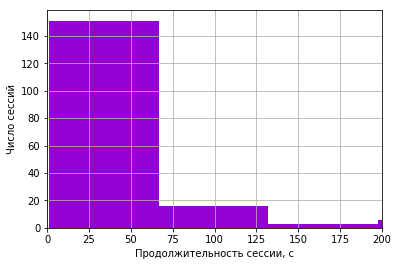

In [21]:
#train_data_10users['session_timespan']  ''' ВАШ КОД ЗДЕСЬ '''
train_data_10users['session_timespan'][0:200].hist(bins=12000, color='darkviolet')
plt.xlim([0, 200]); plt.xlabel('Продолжительность сессии, с'); plt.ylabel('Число сессий');

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

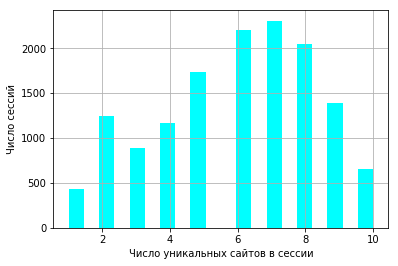

In [52]:
#train_data_10users['#unique_sites']  ''' ВАШ КОД ЗДЕСЬ '''
train_data_10users['#unique_sites'].hist(bins=20, color='aqua')
plt.xlabel('Число уникальных сайтов в сессии'); plt.ylabel('Число сессий');

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

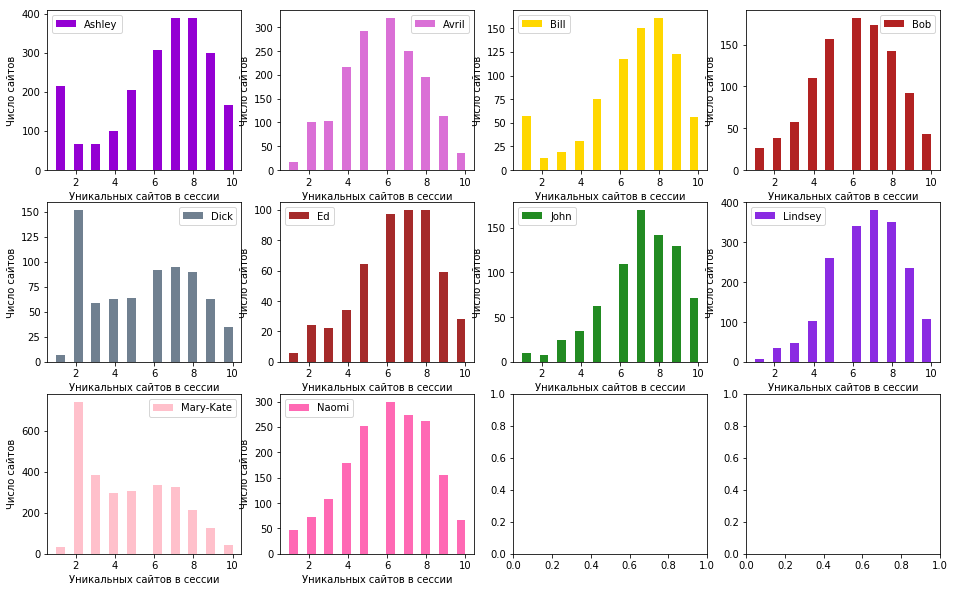

In [51]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
#for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'user_id')): 
    #''' ВАШ КОД ЗДЕСЬ '''
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'target')): 
    #''' ВАШ КОД ЗДЕСЬ '''
    axes[idx//4, idx%4].hist(sub_df['#unique_sites'], color=color_dic[user], bins=20)
    axes[idx//4, idx%4].legend([user]); axes[idx//4, idx%4].set_xlabel('Уникальных сайтов в сессии'); axes[idx//4, idx%4].set_ylabel('Число сайтов')

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

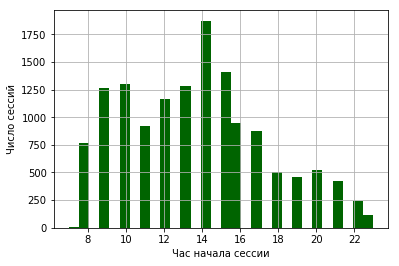

In [28]:
#train_data_10users['start_hour'] ''' ВАШ КОД ЗДЕСЬ '''
train_data_10users['start_hour'].hist(bins=30, color='darkgreen')
plt.xlabel('Час начала сессии'); plt.ylabel('Число сессий');

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

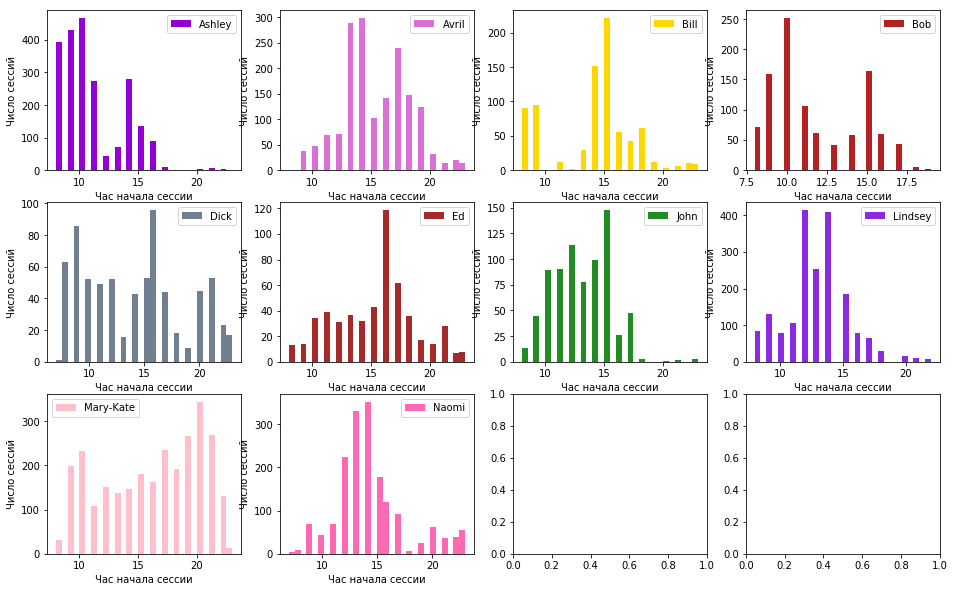

In [60]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
#for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'user_id')): 
#     ''' ВАШ КОД ЗДЕСЬ '''
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'target')): 
    # ''' ВАШ КОД ЗДЕСЬ '''
    axes[idx//4, idx%4].hist(sub_df['start_hour'], color=color_dic[user], bins=30)
    axes[idx//4, idx%4].legend([user]); axes[idx//4, idx%4].set_xlabel('Час начала сессии'); axes[idx//4, idx%4].set_ylabel('Число сессий')        
        

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

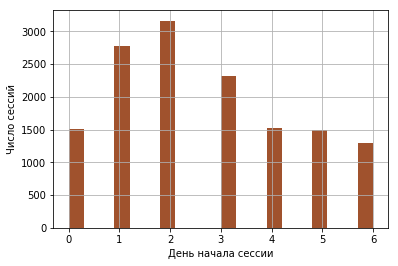

In [37]:
#train_data_10users['day_of_week'] ''' ВАШ КОД ЗДЕСЬ '''
train_data_10users['day_of_week'].hist(bins=20, color='sienna')
plt.xlabel('День начала сессии'); plt.ylabel('Число сессий');

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

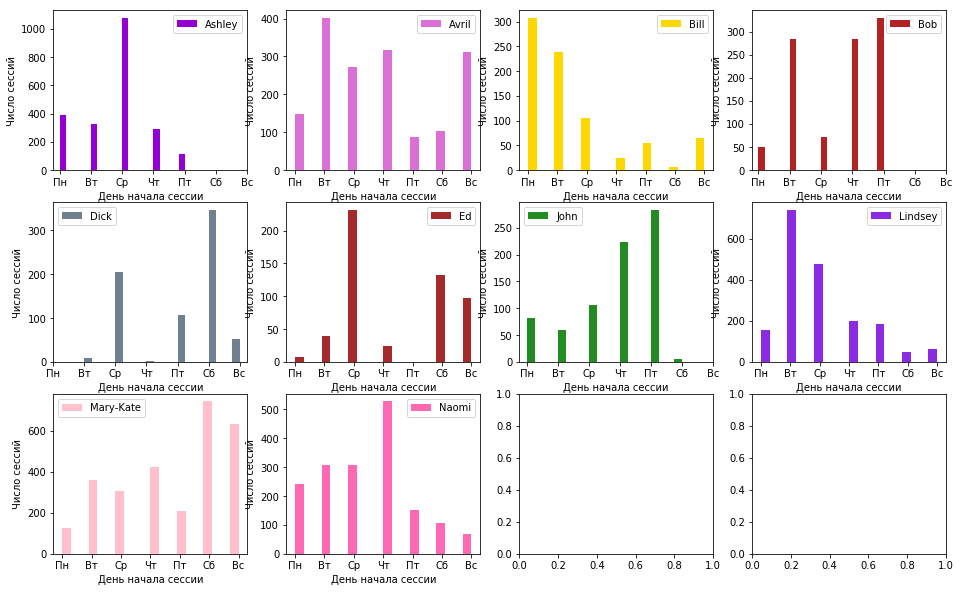

In [50]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
#for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'user_id')): 
 #    ''' ВАШ КОД ЗДЕСЬ '''
ls_days = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'target')): 
    # ''' ВАШ КОД ЗДЕСЬ '''
    axes[idx//4, idx%4].hist(sub_df['day_of_week'], color=color_dic[user], bins=20);
    axes[idx//4, idx%4].set_xticks(range(len(ls_days))); axes[idx//4, idx%4].set_xticklabels(ls_days)
    axes[idx//4, idx%4].legend([user]); axes[idx//4, idx%4].set_xlabel('День начала сессии'); axes[idx//4, idx%4].set_ylabel('Число сессий')        

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

''' ВАШЕ ОПИСАНИЕ ЗДЕСЬ '''
- п.1) продолжительность большинства сессий по всем пользователям не превышает 1 минуты (60 с);
- п.2) число уникальных сайтов в каждой сессии по всем пользователям чаще всего равно 6-7;
- п.3) число уникальных сайтов в каждой сессии для конкретных пользователей так же чаще всего равно 6-7, за исключением пользователей Dick и Mary-Kate (эти пользователи, очевидно, предпочитают чаще заходить на одни и те же сайты);
- п.4) наиболее популярный час начала сессий по всем пользователям - 14:00;
- п.5) начало сессий для большинства пользователей приходится на время 14:00-16:00 (15:00 - визуально наиболее популярное время для начала сессий), но 2 пользователя (Ashley и Bob) предпочитают заходить на сайты в 10:00, а один пользователь (Mary-Kate) предпочитает посещать сайты вечером (пик приходится на 20:00);
- п.6) наиболее популярный день для посещения сайтов по всем пользователям - среда;
- п.7) некоторые пользователи (Avril, Dick, Ed и Mary-Kate) проявляют бОльшую или достаточную активность в выходные, остальные препочитают посещать сайты в будние дни. При этом можно сказать, что наименее популярный день посещения сайтов у большинства пользователей - понедельник.

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [69]:
#with open ''' ВАШ КОД ЗДЕСЬ '''
with open('site_freq_10users.pkl', 'rb') as site_freq_pkl:
    site_freq_10users = pickle.load(site_freq_pkl)

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [93]:
import operator
site_freq_10users_sorted = sorted(site_freq_10users.items(), key=operator.itemgetter(1))

In [97]:
#top10_freqs = ''' ВАШ КОД ЗДЕСЬ '''
#top10_sites = ''' ВАШ КОД ЗДЕСЬ '''
top10_freqs = list(map(lambda x: x[1][1], site_freq_10users_sorted[0:10]))
top10_sites = list(map(lambda x: x[0], site_freq_10users_sorted[0:10]))

**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

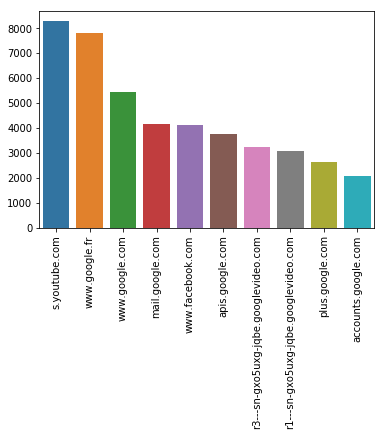

In [102]:
#sns.barplot ''' ВАШ КОД ЗДЕСЬ '''
sns.barplot(x=top10_sites, y=top10_freqs)
plt.xticks(rotation=90);

## Часть 3. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

Попробуем создать один новый признак - медианное время пребывания в сессии, где само время пребывания в сессии считается по разности соседних timestamps-ов (разность между заходами пользователя на два соседних сайта).

In [279]:
# for EXAMPLE
path_to_csv_files = PATH_TO_DATA + '\\10users'
site_freq_path = PATH_TO_DATA + '\\site_freq_10users.pkl'
feature_names = ['median_time', 'target']
session_length = 10
window_size = 10

In [304]:
#def feature_engineering(path_to_csv_files, features, session_length=10):
def feature_engineering(path_to_csv_files, site_freq_path, feature_names, session_length=10, window_size=10):
    ''' ВАШ КОД ЗДЕСЬ ''' 
    ''' ВАШ КОД ЗДЕСЬ '''
    # считаем из pickle-файла словарь с сайтами, их идентификаторами и частотами посещений
    # по всем пользователям в заданном каталоге
    with open(site_freq_path, 'rb') as site_freq_pkl:
        d_site_freq = pickle.load(site_freq_pkl) 
    
    files_pathes = glob(path_to_csv_files + '\\*.csv') # пути к файлам с данными пользователей в заданном каталоге

    # сформируем датафрейм с уникальными сессиями для пользователей
    if window_size <= 0: # проверим положительность размера окна
        window_size = session_length
    
    ls_timesites_median = [] # список медианных значений времени пребывания на сайтах по всем сессиям всех пользователей
            # время пребывания на сайте считается по разности соседних timestamps
    ls_user_id = [] # список идентификаторов пользователей
    
    for file_path in files_pathes:
        df = pd.read_csv(file_path) # считываем очередной файл в датафрейм
        ls_site_ids = [d_site_freq[site][0] for site in df.site] # формируем список идентификаторов сайтов для всего считанного файла
        ls_timestamps = [pd.Timestamp(timestamp).timestamp() for timestamp in df.timestamp] # список timestamp для всего считанного файла
        
        ls_sample_indptrs = list(range(0, int(df.shape[0]/window_size + 0.5)*window_size, window_size)) # список индексов, 
                # начиная с которых необходимо будет выбирать идентификаторы сайтов из списка идентификаторов сайтов
        if (len(ls_site_ids) - window_size) > ls_sample_indptrs[-1]: # учитывает случаи, когда не посчитался последний нужный индекс для выборки
            ls_sample_indptrs.append(ls_sample_indptrs[-1] + window_size)
        ls_timesites_median += [np.median(list(map(lambda x,y: y-x, ls_timestamps[ind:ind+session_length], ls_timestamps[ind:ind+session_length][1:]))) for ind in ls_sample_indptrs]
        ls_user_id += [int(file_path[-8:-4])]*len(ls_sample_indptrs)
        #list(zip((ls_site_ids_temp.count(item) for item in set(ls_site_ids_temp)), set(ls_site_ids_temp)))[:]           
        
    df_train_data = pd.DataFrame(list(zip(ls_timesites_median, ls_user_id)))
    df_train_data.columns = feature_names
    df_train_data.index = range(df_train_data.shape[0])

    return df_train_data

In [305]:
#new_features_10users = feature_engineering ''' ВАШ КОД ЗДЕСЬ ''' 
new_features_10users = feature_engineering(os.path.join(PATH_TO_DATA, '10users'),
                                           site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'),
                                           feature_names=feature_names, session_length=10)

In [307]:
#new_features_150users = feature_engineering ''' ВАШ КОД ЗДЕСЬ ''' 
new_features_150users = feature_engineering(os.path.join(PATH_TO_DATA, '150users'),
                                           site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_150users.pkl'),
                                           feature_names=feature_names, session_length=10)

**10. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

Гистограмма распределения медианного значения времени пребывания на сайте по всем пользователям.

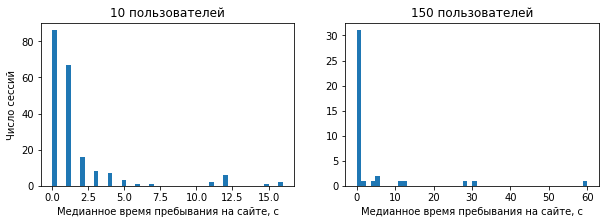

In [363]:
''' ВАШ КОД ЗДЕСЬ ''' 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
axes[0].hist(new_features_10users['median_time'][0:200], bins=50); axes[0].set_xlabel('Медианное время пребывания на сайте, с'); axes[0].set_ylabel('Число сессий')
axes[0].set_title('10 пользователей'); axes[1].set_title('150 пользователей')
axes[1].hist(new_features_150users['median_time'][0:40], bins=50); axes[1].set_xlabel('Медианное время пребывания на сайте, с');

Гистограмма распределения медианного значения времени пребывания на сайте по каждому пользователю для 10-ти пользователей.

In [367]:
new_features_10users['target'] = new_features_10users['target'].map(id_name_dict)

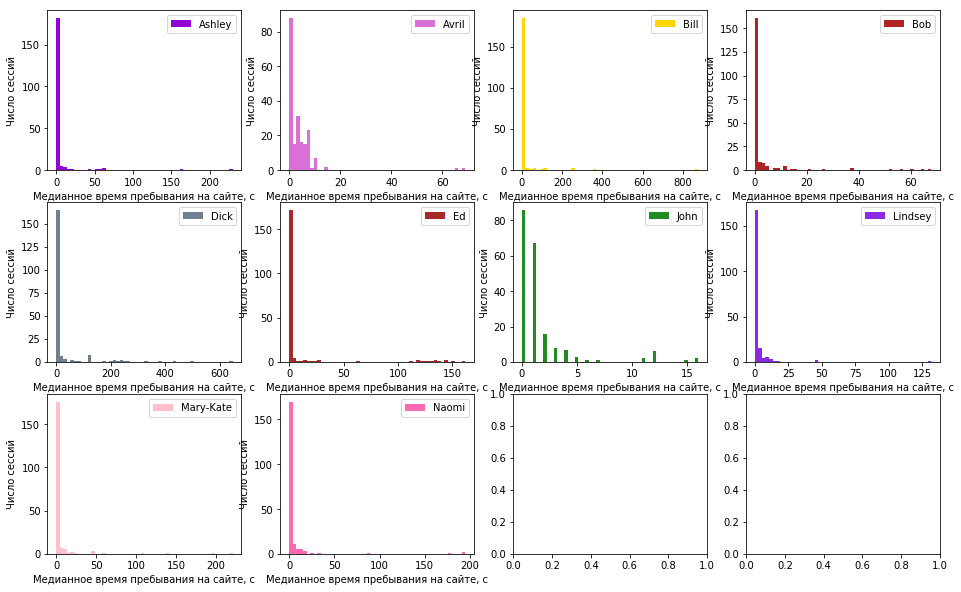

In [371]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
for idx, (user, sub_df) in  enumerate(pd.groupby(new_features_10users, 'target')): 
    # ''' ВАШ КОД ЗДЕСЬ '''
    axes[idx//4, idx%4].hist(sub_df['median_time'][0:200], color=color_dic[user], bins=50);
    axes[idx//4, idx%4].legend([user]); axes[idx//4, idx%4].set_xlabel('Медианное время пребывания на сайте, с'); axes[idx//4, idx%4].set_ylabel('Число сессий')        

По построенным диаграммам можно сделать вывод, что медианное время пребывания на сайте очень не велико и сосредоточено в районе 1-2 с.

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [372]:
#selected_features_10users = ''' ВАШ КОД ЗДЕСЬ ''' 
#selected_features_150users = ''' ВАШ КОД ЗДЕСЬ ''' 
selected_features_10users = new_features_10users.median_time 
selected_features_150users = new_features_150users.median_time 

In [374]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)

### Критерии оценки работы (только для Peer Review в специализации):
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Правильно ли посчитана медианная продолжительность сессий в п. 10? (max. 3 балла)
- Правильно ли посчитан медианный день недели начала сессии в п. 11? (max. 3 балла)
- Правильно ли посчитан медианный час начала сессии в п. 12? (max. 3 балла)
- Правильно ли посчитано медианное значение числа уникальных сайтов в сессиях 150 пользователей п. 13? (max. 3 балла)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)

## Пути улучшения
Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящие статьи по этому ремеслу – [раз](https://habrahabr.ru/post/308162/) и  [два](https://habrahabr.ru/company/ods/blog/323210/))
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями типа [Multicore-TSNE](https://github.com/DmitryUlyanov/Multicore-TSNE), не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

На следующей неделе мы наконец приступим к обучению моделей классификации. 